In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/Preprocessed_Bank_Customer_Churn_Prediction.csv')

# # 사용할 피처 선택 (customer_id 제거)
features = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,850,2,1,43,2,125510.82,1,1,1,79084.10,0


In [26]:
from sklearn.metrics import roc_curve, auc

def auc_plot(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [27]:
# 'balance'와 'estimated_salary' 컬럼을 skewed_columns 리스트에 추가
skewed_columns = ['age', 'balance', 'estimated_salary', 'credit_score']  # 'balance'와 'estimated_salary' 추가
# skewed_columns = ['balance', 'estimated_salary', 'credit_score']  # 'balance'와 'estimated_salary' 추가
# skewed_columns = ['age', 'balance', 'estimated_salary']  # 'balance'와 'estimated_salary' 추가
skewed_columns = ['age']  # 'balance'와 'estimated_salary' 추가

# log1p 변환 함수
def log1p_transform_columns(df, columns):
    for column in columns:
        df[column] = np.log1p(df[column])  # np.log1p는 log(x+1)
    return df

# log1p 변환 수행
df = log1p_transform_columns(df, skewed_columns)

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,1,3.761200,2,0.00,1,1,1,101348.88,1
1,608,2,1,3.737670,1,83807.86,1,0,1,112542.58,0
2,502,0,1,3.761200,8,159660.80,3,1,0,113931.57,1
3,699,0,1,3.688879,1,0.00,2,0,0,93826.63,0
4,850,2,1,3.784190,2,125510.82,1,1,1,79084.10,0


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 정규화 (Normalization) - 0과 1 사이로 변환
scaler = MinMaxScaler()

X = df[features]
y = df['churn']

X.iloc[:, :-1] = scaler.fit_transform(X.iloc[:, :-1])

print(X.head())

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

   credit_score       age  tenure   balance  products_number  credit_card  \
0         0.538  0.514281     0.2  0.000000         0.000000            1   
1         0.516  0.499465     0.1  0.334031         0.000000            0   
2         0.304  0.514281     0.8  0.636357         0.666667            1   
3         0.698  0.468744     0.1  0.000000         0.333333            0   
4         1.000  0.528757     0.2  0.500246         0.000000            1   

   active_member  estimated_salary  
0              1         101348.88  
1              1         112542.58  
2              0         113931.57  
3              0          93826.63  
4              1          79084.10  


/var/folders/qv/kf5vm6ln5k113k6v46_6ynn00000gn/T/ipykernel_14522/656557753.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.538 0.516 0.304 ... 0.718 0.844 0.884]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[:, :-1] = scaler.fit_transform(X.iloc[:, :-1])
/var/folders/qv/kf5vm6ln5k113k6v46_6ynn00000gn/T/ipykernel_14522/656557753.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.2 0.1 0.8 ... 0.7 0.3 0.4]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[:, :-1] = scaler.fit_transform(X.iloc[:, :-1])
/var/folders/qv/kf5vm6ln5k113k6v46_6ynn00000gn/T/ipykernel_14522/656557753.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.66666667 ... 0.

In [29]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

ada_best_params = {}
ada = AdaBoostClassifier(random_state=42, **ada_best_params)
# VotingClassifier 정의
cat_best_params = {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}
cat = CatBoostClassifier(random_state=42, **cat_best_params)
# 최적 Recall 하이퍼파라미터 설정
xgb_best_params = {
    'colsample_bytree': 0.998835926756326,
    'learning_rate': 0.05918736154295684,
    'max_depth': 4,
    'min_child_weight': 4,
    'n_estimators': 152,
    'subsample': 0.7171956369176462,
    'scale_pos_weight': 1.9,  # Recall 최적화된 비율
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
}
xgb = XGBClassifier(random_state=42, **xgb_best_params)
rf_best_params = {'n_estimators':200, 'max_depth':15, 'min_samples_leaf':2, 'min_samples_split':5}
rf = RandomForestClassifier(random_state=42, **rf_best_params)

0:	learn: 0.6464634	total: 1.94ms	remaining: 192ms
1:	learn: 0.6053348	total: 10.9ms	remaining: 535ms
2:	learn: 0.5745701	total: 12.5ms	remaining: 404ms
3:	learn: 0.5467781	total: 14.4ms	remaining: 345ms
4:	learn: 0.5238689	total: 15.6ms	remaining: 297ms
5:	learn: 0.5037690	total: 16.6ms	remaining: 260ms
6:	learn: 0.4861531	total: 17.6ms	remaining: 234ms
7:	learn: 0.4710029	total: 18.6ms	remaining: 214ms
8:	learn: 0.4580213	total: 19.3ms	remaining: 196ms
9:	learn: 0.4468045	total: 20.1ms	remaining: 181ms
10:	learn: 0.4368222	total: 20.8ms	remaining: 169ms
11:	learn: 0.4281312	total: 21.6ms	remaining: 159ms
12:	learn: 0.4208029	total: 22.4ms	remaining: 150ms
13:	learn: 0.4155846	total: 23.7ms	remaining: 145ms
14:	learn: 0.4089106	total: 24.9ms	remaining: 141ms
15:	learn: 0.4035765	total: 25.9ms	remaining: 136ms
16:	learn: 0.3992297	total: 26.9ms	remaining: 131ms
17:	learn: 0.3945264	total: 28.1ms	remaining: 128ms
18:	learn: 0.3909941	total: 29.1ms	remaining: 124ms
19:	learn: 0.3877919	t

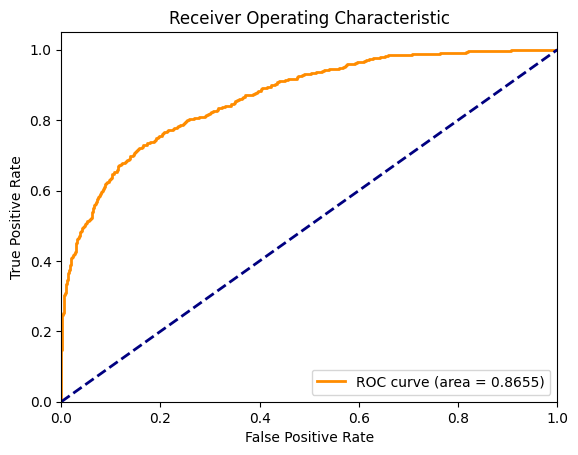

In [ ]:
from sklearn.metrics import classification_report
# votting
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

estimators = [
    ('cat', cat),
    # ('xgb', xgb),
    ('rf', rf),
    ('ada', ada)
]

voting = VotingClassifier(estimators=estimators, voting='soft')

voting.fit(X_train, y_train)

y_pred = voting.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(voting, X_test, y_test)